In [ ]:
from qiskit_ibm_provider import IBMProvider


In [ ]:
provider = IBMProvider('e485d342bdc1db8e8f5af875971bc7a9b620739623f52d8124bfe985a4cc21fba43246e318346b9e89a6b795f022ab64edd78a1490409174af435fff3cca5291')


In [ ]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit_aer import AerSimulator

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive inside a session. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# with Session(backend=service.backend("ibmq_qasm_simulator")):
#     result = Sampler().run(circuits).result()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random

In [ ]:
from qiskit_aer import AerSimulator
from qiskit import QuantumRegister, QuantumCircuit,Aer, execute,ClassicalRegister

In [ ]:
def compute_cost(n, w, G):
    """
    Calcula el costo de cada posible configuración de un sistema dado representado por un grafo y retorna el costo máximo y su configuración correspondiente.

    Parámetros
    ----------
    n : int
        El número de nodos en el grafo.
    w : numpy.ndarray
        Matriz de pesos de las aristas en el grafo.
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    pos : dict
        Un diccionario que mapea cada nodo a su posición en el grafo.

    Devoluciones
    -----------
    cost_dict : dict
        Un diccionario que mapea cada posible configuración del sistema a su costo asociado.
    best_cost_brute : int
        El costo máximo encontrado entre todas las configuraciones posibles.

    Ejemplo
    -------
    >>> cost_dict, best_cost_brute = compute_cost(n, w, G, pos)
    >>> print(best_cost_brute)
    15
    >>> print(cost_dict)
    {(0, 0, 0): 0, (0, 0, 1): 5, ..., (1, 1, 1): 15}
    """
    best_cost_brute = 0
    cost_dict = {}  # Diccionario para almacenar los casos y sus costos

    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = 0
        for i in range(n):
            for j in range(n):
                cost = cost + w[i, j] * x[i] * (1 - x[j])
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x
        
        # Almacena el caso y el costo en el diccionario
        cost_dict[tuple(x)] = cost

    colors = ["r" if xbest_brute[i] == 0 else "c" for i in range(n)]
    #draw_graph(G, colors, pos)

    return cost_dict, best_cost_brute


In [ ]:
def generate_hamiltonian_graph(num_nodes):
    """
    Genera un grafo Hamiltoniano no dirigido con un número dado de nodos y aristas adicionales aleatorias.

    Un grafo Hamiltoniano es un grafo que tiene un ciclo Hamiltoniano (un ciclo que visita cada nodo una vez).
    Esta función primero crea un ciclo que conecta todos los nodos, y luego agrega aristas adicionales de manera aleatoria.

    Parámetros
    ----------
    num_nodes : int
        El número de nodos para incluir en el grafo.

    Devoluciones
    ------------
    G : networkx.classes.graph.Graph
        Un objeto de grafo no dirigido de NetworkX con 'num_nodes' nodos, un ciclo Hamiltoniano,
        y aristas adicionales que se añaden aleatoriamente.

    Ejemplo
    -------
    >>> G = generate_hamiltonian_graph(5)
    >>> print(G.edges(data=True))
    [(0, 1, {'weight': 1.0}), (0, 4, {'weight': 1.0}), (1, 2, {'weight': 1.0}), 
    (2, 3, {'weight': 1.0}), (3, 4, {'weight': 1.0})]
    """
    # Crea un nuevo grafo no dirigido
    G = nx.Graph()

    # Agrega los nodos al grafo
    G.add_nodes_from(range(num_nodes))

    # Genera un camino Hamiltoniano
    for i in range(num_nodes - 1):
        G.add_edge(i, i + 1, weight=1.0)
    G.add_edge(num_nodes - 1, 0, weight=1.0)  # Cierra el ciclo para hacerlo Hamiltoniano

    # Agrega más aristas de manera aleatoria
    for i in range(num_nodes):
        for j in range(i + 2, num_nodes):
            if np.random.random() > 0.5:  # Añade la arista con una probabilidad del 50%
                G.add_edge(i, j, weight=1.0)

    return G

In [ ]:
def compute_weight_matrix(G, n):
    """
    Calcula la matriz de pesos a partir de un grafo dado.

    Parámetros
    ----------
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    n : int
        El número de nodos en el grafo.

    Devoluciones
    -----------
    w : numpy.ndarray
        Una matriz de 'n' por 'n' que representa los pesos de las aristas en el grafo. 
        Cada elemento w[i, j] es el peso de la arista entre los nodos i y j.

    Ejemplo
    -------
    >>> w = compute_weight_matrix(G, 5)
    >>> print(w)
    [[0. 1. 1. 1. 1.]
     [1. 0. 1. 1. 1.]
     [1. 1. 0. 1. 1.]
     [1. 1. 1. 0. 1.]
     [1. 1. 1. 1. 0.]]
    """
    # Calculando la matriz de pesos a partir del grafo aleatorio
    w = np.zeros([n, n])
    for i in range(n):
        for j in range(n):
            temp = G.get_edge_data(i, j, default=0)
            if temp != 0:
                w[i, j] = temp["weight"]
    return w


In [ ]:
def draw_graph(G, colors, pos):
    """
    Dibuja un grafo de NetworkX con nodos de colores y etiquetas de aristas.

    Parámetros
    ----------
    G : networkx.classes.graph.Graph
        Un objeto de grafo de NetworkX.
    colors : list
        Una lista de colores para los nodos. Cada nodo se dibuja con el color correspondiente de la lista.
    pos : dict
        Un diccionario que mapea cada nodo a su posición en el grafo.

    Ejemplo
    -------
    >>> draw_graph(G, ['red', 'red', 'cyan', 'cyan', 'cyan'], pos)
    """
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "peso")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

In [ ]:
def string_to_tuple(s):
    """
    Convierte una cadena de texto en una tupla, interpretando cada carácter como un número entero.

    Parámetros
    ----------
    s : str
        La cadena de texto a convertir. Se espera que cada carácter de la cadena sea un dígito decimal.

    Devoluciones
    -----------
    tuple
        Una tupla de enteros correspondiente a los caracteres de la cadena.

    Ejemplo
    -------
    >>> t = string_to_tuple("1234")
    >>> print(t)
    (1, 2, 3, 4)
    """
    return tuple(int(char) for char in s)

In [ ]:
def get_random_number(qc, qubit, reg):
    """
    Genera un número aleatorio (0 o 1) utilizando un circuito cuántico.

    Parámetros
    ----------
    qc : qiskit.circuit.quantumcircuit.QuantumCircuit
        El circuito cuántico en el que se realizará la operación.
    qubit : qiskit.circuit.quantumregister.QuantumRegister
        El registro cuántico que contiene los qubits en los que se realizará la operación.
    reg : qiskit.circuit.classicalregister.ClassicalRegister
        El registro clásico que se utilizará para la medición.

    Devoluciones
    -----------
    first_digit : int
        Un número aleatorio (0 o 1) generado a partir de la medida del estado del qubit.

    Ejemplo
    -------
    >>> qc = QuantumCircuit(1, 1)
    >>> qubit = QuantumRegister(1)
    >>> reg = ClassicalRegister(1)
    >>> random_number = get_random_number(qc, qubit, reg)
    >>> print(random_number)
    0
    """
    qc.h(qubit[0])
    qc.measure(qubit[0], reg[0])
    
    with qc.if_test((reg, 1)):
        qc.x(qubit[0])

    backend_sim = AerSimulator()
    reset_sim_job = backend_sim.run(qc, shots = 1)
    reset_sim_result = reset_sim_job.result()
    counts = reset_sim_result.get_counts(qc)

    key = list(counts.keys())[0]
    first_digit = int(key[0])  # Convierte el primer carácter de la clave a un entero
    return first_digit

In [ ]:
def mutate_bit(qr, qc, bit):
    """
    Aplica una operación NOT (X) a un bit específico de un registro cuántico.
    
    Parámetros
    ----------
    qr : QuantumRegister
        El registro cuántico en el que se realizará la mutación.
    qc : QuantumCircuit
        El circuito cuántico que contiene el registro.
    bit : int
        El índice del bit que se va a mutar.
        
    Devoluciones
    ------------
    No devuelve nada; la función modifica el circuito cuántico directamente.
    """
    qc.x(qr[bit])


def mutate_multi_bit(qr, qc, probabilidad):
    """
    Aplica una operación NOT (X) a cada bit en un registro cuántico con cierta probabilidad.
    
    Parámetros
    ----------
    qr : QuantumRegister
        El registro cuántico en el que se realizarán las mutaciones.
    qc : QuantumCircuit
        El circuito cuántico que contiene el registro.
    probabilidad : float
        La probabilidad de que cada bit sea mutado.
        
    Devoluciones
    ------------
    No devuelve nada; la función modifica el circuito cuántico directamente.
    """
    for i in range(len(qr)):
        if np.random.random() > probabilidad:
            mutate_bit(qr, qc, i)


def mutate_bit_random(qr, qc, probabilidad):#prob >0 and prob <1 a mas grande prob menos oportunidades de mutar
    """
    Aplica una operación NOT (X) a un bit aleatorio en un registro cuántico con cierta probabilidad.
    
    Parámetros
    ----------
    qr : QuantumRegister
        El registro cuántico en el que se realizará la mutación.
    qc : QuantumCircuit
        El circuito cuántico que contiene el registro.
    probabilidad : float
        La probabilidad de que el bit sea mutado.
        
    Devoluciones
    ------------
    No devuelve nada; la función modifica el circuito cuántico directamente.
    """
    if np.random.random() > probabilidad:
        qc.x(qr[np.random.randint(0, len(qr))])


def mutate_exchange(qr, qc, probabilidad):
    """
    Intercambia dos bits aleatorios en un registro cuántico con cierta probabilidad.
    
    Parámetros
    ----------
    qr : QuantumRegister
        El registro cuántico en el que se realizará el intercambio.
    qc : QuantumCircuit
        El circuito cuántico que contiene el registro.
    probabilidad : float
        La probabilidad de que se realice el intercambio.
        
    Devoluciones
    ------------
    No devuelve nada; la función modifica el circuito cuántico directamente.
    """
    if np.random.random() > probabilidad:
        numero0 = np.random.randint(0, len(qr))
        numero1 = np.random.randint(0, len(qr))
        if numero0 != numero1:
            qc.swap(qr[numero0], qr[numero1])

In [ ]:
def puntos(qr):
    """
    Genera dos números enteros aleatorios diferentes dentro del rango del tamaño del registro cuántico.

    Parámetros
    ----------
    qr : QuantumRegister
        El registro cuántico que se utiliza para determinar el rango de los números generados.

    Devoluciones
    ------------
    tuple
        Una tupla de dos enteros. El primer elemento de la tupla es siempre menor que el segundo.

    Ejemplo
    -------
    >>> qr = QuantumRegister(5)
    >>> p = puntos(qr)
    >>> print(p)
    (2, 4)  # Los valores exactos pueden variar debido a la generación aleatoria
    """
    numero = np.random.randint(1, len(qr) - 1) 
    num = np.random.randint(1, len(qr) - 1)
    while numero == num:
        num = np.random.randint(1, len(qr) - 1)
    if num > numero:
        return numero, num
    if num <= numero:
        return num, numero


In [ ]:
def escribir(qc, qreg, bin_string):
    """
    Escribe o 'resetea' un registro cuántico, basándose en una cadena de texto binaria.

    Parámetros
    ----------
    qc : QuantumCircuit
        El circuito cuántico que contiene el registro.
    qreg : QuantumRegister
        El registro cuántico que se va a escribir o resetear.
    bin_string : str
        La cadena de texto binaria que se utilizará para escribir o resetear el registro. Si se quiere escribir un
        número específico, esta cadena debe representar el número en binario. Si se quiere resetear el registro, esta
        cadena debe ser la representación binaria actual del estado del registro cuántico.

    Devoluciones
    ------------
    No devuelve nada; la función modifica el circuito cuántico directamente.

    Lanza
    -----
    ValueError
        Si el tamaño del QuantumRegister no es suficientemente grande para el string binario.

    Ejemplo
    -------
    >>> qr = QuantumRegister(5)
    >>> qc = QuantumCircuit(qr)
    >>> escribir(qc, qr, '10101')
    """
    if qreg.size < len(bin_string):
        raise ValueError("El QuantumRegister no es suficientemente grande para el string binario")

    bin_string = bin_string[::-1]

    for i, bit in enumerate(bin_string):
        if bit == '1':
            qc.x(i)


In [ ]:
def create_qc(number_quantum_reg,qubits,number_classic_reg,bits):
    """facilita el crear circuitos cuanticos si quieres poner ancillas aconesjo hacerlo manualmente partiendo desde aqui"""
    # Create quantum registers
    qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
    ancilla = QuantumRegister(1, name='ancilla')
    # Create classical registers
    cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
    cr_ancilla = ClassicalRegister(1, name='cr_ancilla')
    # Create a quantum circuit
    return QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)

In [ ]:
def lanzar_dinamico(circuito, backend,shots):
    """
    Ejecuta un circuito cuántico en un backend específico y devuelve los conteos de resultados.

    Parámetros
    ----------
    circuito : QuantumCircuit
        El circuito cuántico que se va a ejecutar.
    backend : Backend
        El backend de Qiskit en el que se ejecutará el circuito.

    Devoluciones
    ------------
    dict
        Un diccionario que contiene los conteos de resultados de la ejecución del circuito. Las claves son las 
        cadenas de texto binarias que representan los resultados, y los valores son los números de veces que cada 
        resultado ocurrió.

    Ejemplo
    -------
    >>> qc = QuantumCircuit(1)
    >>> qc.h(0)
    >>> backend = Aer.get_backend('qasm_simulator')
    >>> counts = lanzar_dinamico(qc, backend)
    >>> print(counts)
    {'0': 512, '1': 512}
    """
    backend_sim = backend
    #tp_circuit = transpile(circuito, backend=backend, optimization_level=0)
    tp_c = transpile(circuito,backend)
    reset_sim_job = backend_sim.run(tp_c, shots=shots, dynamic=True)
    reset_sim_result = reset_sim_job.result()#esto es para NO ruido
    return reset_sim_result.get_counts()
    """result_noise = sim_vigo.run(tcirc).result()#RUIDO
    return result_noise.get_counts(0)"""

In [ ]:
def valores_hijos(resultados):#se supone que solo tenemos dos creg, es decir dos hijos
    """
    Extrae dos cadenas de texto binarias de los resultados de una ejecución de un circuito cuántico.

    Parámetros
    ----------
    resultados : dict
        El diccionario que contiene los conteos de resultados de la ejecución del circuito. Se espera que las claves
        sean cadenas de texto binarias separadas por espacios.

    Devoluciones
    ------------
    tuple
        Una tupla de dos tuplas de enteros. Cada tupla de enteros corresponde a los dígitos de una de las cadenas de 
        texto binarias.

    Ejemplo
    -------
    >>> resultados = {'1 101 011': 1}
    >>> valores = valores_hijos(resultados)
    >>> print(valores)
    ((0, 1, 1), (1, 0, 1))
    """
    for key in resultados.keys():
        return string_to_tuple(key.split(' ')[2]), string_to_tuple(key.split(' ')[1])

In [ ]:
def tuple_to_string(t):
    """
    Convierte una tupla de enteros en una cadena de texto, interpretando cada número entero como un carácter.

    Parámetros
    ----------
    t : tuple
        La tupla de enteros a convertir. Se espera que cada elemento de la tupla sea un número entero.

    Devoluciones
    ------------
    str
        Una cadena de texto correspondiente a los números de la tupla.

    Ejemplo
    -------
    >>> s = tuple_to_string((1, 2, 3, 4))
    >>> print(s)
    '1234'
    """
    return ''.join(str(num) for num in t)

In [ ]:
def reset(qc, qr, cr_ancilla):
    """
    Resetea todos los qubits en un registro cuántico, midiendo cada qubit y luego aplicando una compuerta X si el resultado de la medición es 1.

    Parámetros
    ----------
    qc : QuantumCircuit
        El circuito cuántico donde se realizará el reseteo.

    qr : QuantumRegister
        El registro cuántico que contiene los qubits a resetear.

    cr_ancilla : ClassicalRegister
        El registro clásico auxiliar utilizado para almacenar los resultados de las mediciones.

    Ejemplo
    -------
    >>> from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
    >>> qr = QuantumRegister(3)
    >>> cr_ancilla = ClassicalRegister(1)
    >>> qc = QuantumCircuit(qr, cr_ancilla)
    >>> reset(qc, qr, cr_ancilla)
    """
    for qubit in range(0, qr.size):
        qc.measure(qr[qubit], cr_ancilla)
        with qc.if_test((cr_ancilla, 1)):
            qc.x(qr[qubit])


In [ ]:
def crear_hijo(base, hasta, maximo, qreg_padre, qreg_madre, qreg_hijo, qc, qreg_ancilla, cr_ancilla):
    """
    Crea un nuevo registro cuántico hijo a partir de dos registros cuánticos padres utilizando el algoritmo genético.

    Parámetros
    ----------
    base : int
        El índice en el que comienza la sección intermedia del hijo.
    hasta : int
        El índice en el que termina la sección intermedia del hijo.
    maximo : int
        El tamaño total del registro cuántico.
    qreg_padre : QuantumRegister
        El registro cuántico del primer progenitor.
    qreg_madre : QuantumRegister
        El registro cuántico del segundo progenitor.
    qreg_hijo : QuantumRegister
        El registro cuántico del hijo que se va a crear.
    qc : QuantumCircuit
        El circuito cuántico en el que se realizarán las operaciones.
    qreg_ancilla : QuantumRegister
        El registro cuántico de ancilla utilizado para las operaciones.
    cr_ancilla : ClassicalRegister
        El registro clásico de ancilla utilizado para las operaciones.

    Devoluciones
    ------------
    No devuelve nada; la función modifica el QuantumCircuit directamente.

    Ejemplo
    -------
    >>> qr_padre = QuantumRegister(5, 'padre')
    >>> qr_madre = QuantumRegister(5, 'madre')
    >>> qr_hijo = QuantumRegister(5, 'hijo')
    >>> qc = QuantumCircuit(qr_padre, qr_madre, qr_hijo)
    >>> qr_ancilla = QuantumRegister(1, 'ancilla')
    >>> cr_ancilla = ClassicalRegister(1, 'cr_ancilla')
    >>> qc.add_register(qr_ancilla, cr_ancilla)
    >>> base = 1
    >>> hasta = 3
    >>> maximo = 5
    >>> crear_hijo(base, hasta, maximo, qr_padre, qr_madre, qr_hijo, qc, qr_ancilla, cr_ancilla)
    """
    
    #if get_random_number(qc, qreg_ancilla, cr_ancilla) == 0:#se genera un numero aleatorio que indicara si se usa al padre o a la madre
    
    if np.random.randint(0,2) ==0:#del 0 al 1 random
        padre_hijo(qc, qreg_padre, qreg_hijo, qreg_ancilla, cr_ancilla, 0, base)
    if np.random.randint(0,2) ==1:
        padre_hijo(qc, qreg_madre, qreg_hijo, qreg_ancilla, cr_ancilla, 0, base)

    padre_hijo(qc, qreg_padre, qreg_hijo, qreg_ancilla, cr_ancilla, base, hasta)#medio
    padre_hijo(qc, qreg_madre, qreg_hijo, qreg_ancilla, cr_ancilla, hasta, maximo)#fin


In [ ]:
def padre_hijo(circuit, qreg_padre, qreg_hijo, qreg_ancilla, cr_ancilla, base, hasta):
    """
    Realiza el cruce entre el registro cuántico de un progenitor y el registro cuántico de un hijo.

    Parámetros
    ----------
    circuit : QuantumCircuit
        El circuito cuántico en el que se realizarán las operaciones.
    qreg_padre : QuantumRegister
        El registro cuántico del progenitor.
    qreg_hijo : QuantumRegister
        El registro cuántico del hijo.
    qreg_ancilla : QuantumRegister
        El registro cuántico de ancilla utilizado para las operaciones.
    cr_ancilla : ClassicalRegister
        El registro clásico de ancilla utilizado para las operaciones.
    base : int
        El índice en el que comienza la sección a cruzar.
    hasta : int
        El índice en el que termina la sección a cruzar.

    Devoluciones
    ------------
    No devuelve nada; la función modifica el QuantumCircuit directamente.

    Ejemplo
    -------
    >>> qr_padre = QuantumRegister(5, 'padre')
    >>> qr_hijo = QuantumRegister(5, 'hijo')
    >>> qc = QuantumCircuit(qr_padre, qr_hijo)
    >>> qr_ancilla = QuantumRegister(1, 'ancilla')
    >>> cr_ancilla = ClassicalRegister(1, 'cr_ancilla')
    >>> qc.add_register(qr_ancilla, cr_ancilla)
    >>> base = 1
    >>> hasta = 3
    >>> padre_hijo(qc, qr_padre, qr_hijo, qr_ancilla, cr_ancilla, base, hasta)
    """
    for i in range(base, hasta):
        circuit.cx(qreg_padre[i], qreg_hijo[i])
        circuit.x(qreg_padre[i])
        circuit.x(qreg_hijo[i])
        circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
        circuit.x(qreg_padre[i])
        circuit.x(qreg_hijo[i])
        circuit.cx(qreg_ancilla[0], qreg_hijo[i])
        circuit.x(qreg_hijo[i])
        circuit.x(qreg_ancilla[0])
        circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
        circuit.ccx(qreg_padre[i], qreg_hijo[i], qreg_ancilla[0])
        circuit.ccx(qreg_padre[i], qreg_ancilla[0], qreg_hijo[i])
        circuit.measure(qreg_ancilla[0], cr_ancilla[0])
        with circuit.if_test((cr_ancilla[0], 1)):
            circuit.x(qreg_ancilla[0])

In [ ]:
def calculate_cut(partition_string, weight_matrix):
    """
    Calcula el número de aristas que cruzan la partición.

    Parámetros
    ----------
    partition_string : str
        Una cadena binaria que representa la partición. 
        Cada carácter en la cadena representa un nodo en el grafo. 
        Un '0' significa que el nodo está en un lado de la partición, 
        y un '1' significa que está en el otro lado.
    weight_matrix : numpy.ndarray
        Una matriz que representa los pesos de las aristas en el grafo. 
        Cada elemento w[i, j] es el peso de la arista entre los nodos i y j.

    Devoluciones
    -----------
    cut : int
        El número de aristas que cruzan la partición.
    """
    cut = 0
    for i in range(len(partition_string)):
        for j in range(i+1, len(partition_string)): # Evita contar dos veces la misma arista
            if partition_string[i] != partition_string[j]: # Si los nodos están en lados opuestos de la partición
                cut += weight_matrix[i, j] # Añade el peso de la arista al corte
    return cut


In [ ]:
def qga(number_quantum_reg,qubits,number_classic_reg,bits,cost_dict,probabilidad,mejor,backend,inicial,weight_matrix):

    """
    qga(number_quantum_reg, qubits, number_classic_reg, bits, cost_dict, probabilidad, mejor, backend)

    Algoritmo genético cuántico que realiza una búsqueda de soluciones en un espacio cuántico.

    Parámetros:
    ------------
    number_quantum_reg: int
        Número de registros cuánticos a utilizar en el circuito.

    qubits: int
        Número de qubits en cada registro cuántico.

    number_classic_reg: int
        Número de registros clásicos a utilizar en el circuito.

    bits: int
        Número de bits en cada registro clásico.

    cost_dict: dict
        Un diccionario con los costos asociados a cada posible solución.

    probabilidad: float
        Probabilidad utilizada para las operaciones de mutación.

    mejor: tuple
        La mejor solución conocida hasta el momento.

    backend: Provider
        El backend en el que se ejecutará el circuito.
    
    inicial: tuple
        La solución inicial desde donde el algoritmo comenzará la búsqueda.

    Devuelve:
    ----------
    result: tuple
        La mejor solución encontrada por el algoritmo.

    Ejemplo:
    ---------
    >>> number_quantum_reg = 4
    >>> qubits = 6
    >>> number_classic_reg = 2
    >>> bits = 6
    >>> cost_dict = {(0, 1, 0, 0, 0, 1): 5.0, ...}
    >>> probabilidad = 0.1
    >>> mejor = (1, 0, 1, 1, 0, 0)
    >>> backend = Aer.get_backend('qasm_simulator')
    >>> qga(number_quantum_reg, qubits, number_classic_reg, bits, cost_dict, probabilidad, mejor, backend)
    (1, 0, 1, 1, 0, 0)
    """


    #qc = create_qc(number_quantum_reg,qubits,number_classic_reg,bits)
    # Create quantum registers
    estadisticas = []
    #f = open('qga_stats.txt', 'w')
    shots = 10
    qregs = [QuantumRegister(qubits, name=f'q{i}') for i in range(number_quantum_reg)]
    ancilla = QuantumRegister(1, name='ancilla')

    # Create classical registers
    cregs = [ClassicalRegister(bits, name=f'c{i}') for i in range(number_classic_reg)]
    cr_ancilla = ClassicalRegister(1, name='cr_ancilla')
    qc = QuantumCircuit(*qregs, ancilla, *cregs, cr_ancilla)
    generation = 0 
    best = False
    #result = ''
    #case = (0, 1, 0, 0, 0, 1) cost = 5.0 emepzaremos con este reg como padre y el segundo reg en superposicion
    #inicial = (0, 1, 0, 0, 0, 1)
    result=inicial
    escribir(qc,qc.qregs[0],tuple_to_string(inicial))
    for i in range(qc.qregs[1].size):
        qc.h(qc.qregs[1][i])
    #crear_hijo(base,hasta,qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,qc.ancilla,qc.cr_ancilla)#usando al padre
    #crear_hijo(base,hasta,qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,qc.ancilla,qc.cr_ancilla)#usando a la madre
    while generation <10:
        poblaciones_resultados = []
        print("Generation: ",generation)
        #f.write('Generation: '+str(generation) +'\n')
        crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[0],qc.qregs[1],qc.qregs[2],qc,ancilla,cr_ancilla)#usando al padre qc.qregs[-2]  # -2 since ancilla is the second last element added to qregs
        crear_hijo(*puntos(qc.qregs[0]),qubits,qc.qregs[1],qc.qregs[0],qc.qregs[3],qc,ancilla,cr_ancilla)#usando a la madre    
        for i in range(qubits):
            qc.measure(qc.qregs[2][i],qc.cregs[0][i])
            qc.measure(qc.qregs[3][i],qc.cregs[1][i])
        hijo0,hijo1 = valores_hijos(lanzar_dinamico(qc,backend,shots))
        print("recien_crea2 hijo0: ",hijo0,"costo: ",calculate_cut(hijo0, weight_matrix))
        #f.write('recien creado hijo0 : '+", ".join(map(str, hijo0)) +'costo : '+ str(calculate_cut(hijo0, weight_matrix)) +'\n')
        print("recien_crea2 hijo1: ",hijo1,"costo: ",calculate_cut(hijo1, weight_matrix))
        #f.write('recien creado hijo0 : '+", ".join(map(str, hijo1)) +'costo : '+ str(calculate_cut(hijo1, weight_matrix)) +'\n')
        """h0 = calculate_cut(hijo0, weight_matrix)
        h1 = calculate_cut(hijo1, weight_matrix)
        inici = calculate_cut(inicial, weight_matrix)"""
        if cost_dict[hijo0]<cost_dict[hijo1] and cost_dict[inicial]<cost_dict[hijo1]:
        #if hijo0 < h1 and inici < h1:
            escribir(qc,qc.qregs[0],tuple_to_string(hijo1))#borramos la info del padre
            inicial = hijo1
            result = hijo1
        if cost_dict[hijo0]>cost_dict[hijo1] and cost_dict[inicial]<cost_dict[hijo0]:
        #if h0 > h1 and inici < h0:    
            escribir(qc,qc.qregs[0],tuple_to_string(hijo0))#borramos la info del padre
            inicial = hijo0
            result = hijo0
            
        if  cost_dict[hijo0] == mejor:
            result = hijo0
            print("fin!!")
            poblaciones_resultados.append(calculate_cut(hijo0, weight_matrix))
            poblaciones_resultados.append(calculate_cut(hijo1, weight_matrix))
            best = True
            break
            
            #best = True
            
        if  cost_dict[hijo1] == mejor:
            result = hijo1
            #f.write('Primera linea de texto.\n')
            poblaciones_resultados.append(calculate_cut(hijo0, weight_matrix))
            poblaciones_resultados.append(calculate_cut(hijo1, weight_matrix))
            print("fin!!")
            best = True
            break


        
        cual = np.random.randint(0, 4)#aleatorio cual de las 4 mutaciones
        functions = {
            0: lambda: mutate_bit(qc.qregs[0], qc, np.random.randint(0, len(qc.qregs[0]))),
            1: lambda: mutate_multi_bit(qc.qregs[0], qc, probabilidad),
            2: lambda: mutate_bit_random(qc.qregs[0], qc, probabilidad),
            3: lambda: mutate_exchange(qc.qregs[0], qc, probabilidad)
        }
        functions[cual]()
        """h0 = calculate_cut(hijo0, weight_matrix)
        h1 = calculate_cut(hijo1, weight_matrix)
        inici = calculate_cut(inicial, weight_matrix)"""
        #if h0 > h1 and inici < h0:
        if cost_dict[hijo0]>cost_dict[hijo1] and cost_dict[hijo0]> cost_dict[inicial]:
            """if cost_dict[hijo0] == mejor:
                best = True
                break"""
            escribir(qc,qc.qregs[0],tuple_to_string(hijo0))#borramos la info del padre
            inicial = hijo0
            result = hijo0
        #if h0 < h1 and inici < h1:
        if cost_dict[hijo0]<cost_dict[hijo1] and cost_dict[hijo1]> cost_dict[inicial]:
            """if cost_dict[hijo1] == mejor:
                best = True
                break"""
            
            escribir(qc,qc.qregs[0],tuple_to_string(hijo1))#borramos la info del padre
            inicial = hijo1
            result = hijo1
        print("mutaciones_hijo0: ",hijo0,"costo: ",calculate_cut(hijo0, weight_matrix))
        print("mutaciones_hijo1: ",hijo1,"costo: ",calculate_cut(hijo1, weight_matrix))

        print("padre: ",inicial)
        print("hijo0: ",hijo0)
        poblaciones_resultados.append(calculate_cut(hijo0, weight_matrix))
        print("hijo1: ",hijo1)
        poblaciones_resultados.append(calculate_cut(hijo1, weight_matrix))
        estadisticas.append(poblaciones_resultados)
        generation+=1
        print(generation)
    return result,best,estadisticas

In [ ]:
def funcion(number_qubits,shots,backend,tupla):
    """
    Esta función realiza una serie de operaciones en un circuito cuántico, incluyendo inicialización de qubits, 
    aplicaciones de puertas, mediciones y lanzamiento de un simulador cuántico.

    Parámetros
    ----------
    number_qubits : int
        El número de qubits para los registros cuánticos 'q0', 'q1', 'q2'.

    shots : int
        El número de veces que se debe ejecutar el circuito cuántico.

    backend : Backend
        La instancia de backend que se utilizará para ejecutar el circuito cuántico.

    Devoluciones
    -------
    dict
        Un diccionario que representa las cuentas de los resultados de las mediciones.

    Ejemplo
    -------
    >>> from qiskit import Aer
    >>> backend = Aer.get_backend('qasm_simulator')
    >>> counts = funcion(3, 100, backend)
    >>> print(counts)
    """
    
    
    q0 = QuantumRegister(number_qubits, 'q0')
    q1 = QuantumRegister(number_qubits, 'q1')
    q2 = QuantumRegister(number_qubits, 'q2')

    # Crear el qubit ancilla
    ancilla = QuantumRegister(1, 'ancilla')

    # Crear los registros clásicos
    c0 = ClassicalRegister(number_qubits, 'c0')
    c1 = ClassicalRegister(1, 'c1')

    # Crear el circuito cuántico
    qc = QuantumCircuit(q0, q1, q2, ancilla, c0, c1)
    
    #escribir = tuple_to_string((0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0))
    escribir = tuple_to_string(tupla)
    #escribir(qc,q0,"")
    # La cadena binaria que representa el estado al que quieres inicializar tu registro cuántico
    binary_string = escribir

    # Invierte la cadena, ya que los qubits en Qiskit se numeran de derecha a izquierda
    binary_string = binary_string[::-1]

    # Aplica una puerta X a cada qubit que quieras en el estado |1⟩
    for i in range(len(binary_string)):
        if binary_string[i] == '1':
            qc.x(q0[i])
    print(calculate_cut(escribir, w))
    energia_inicial = calculate_cut(escribir, w)
    # Aplica la puerta Hadamard a todos los qubits en q1


    #print("Energia inicial: ",energia_inicial)
    qc.h(q1)


    #qc.measure(q2, c0)

    total = 0
    iteraciones = 0
    bucle = 0
    mejor = energia_inicial
    hijo=None
    while bucle<10:
        print("BUCLE: ",bucle)
        base,hasta = puntos(q0)
        #print("PUNTOS DE CORTE: ",base,hasta)
        crear_hijo(base,hasta,number_qubits,q0,q1,q2,qc,ancilla,c1)
        #print(iteraciones)
        qc.measure(q2, c0)
        #backend = Aer.get_backend('qasm_simulator')
        #backend = AerSimulator()
        c=lanzar_dinamico(qc,backend,shots)#usando shots = 5 en los primeros ejemplos
        #print("LOS COUNTS IMPORTAN: ",c)
        print("Printeamos c:",c)
        total = 0
        """AQUI CALCULAMOS LA MEDIA, METER ESTE CODIGO EN UNA FUNCION"""
        for key, value in c.items():
            #key = list(results.keys())[0]
        # Divide la clave por el espacio y toma el segundo elemento
            measurement = key.split(' ')[1]
            #print(measurement)
            #print(measurement)
            r = calculate_cut(measurement, w)
            total = total + (r*value)
        evaluacion_hijo = total / shots
        """HASTA AQUI!!!!"""
        #print("EVALUACION: ",evaluacion_hijo)
        if energia_inicial < evaluacion_hijo:
            #print("SIII")
            #mejor = 0
            for key, value in c.items():


                #key = list(results.keys())[0]
                # Divide la clave por el espacio y toma el segundo elemento
                measurement = key.split(' ')[1]
                print("inical:", key.split(' ')[1])
                print("obtenido: ",measurement)
                if energia_inicial < calculate_cut(measurement, w) and mejor < calculate_cut(measurement, w):
                    hijo=measurement


            #padre_hijo(qc, q2, q0, ancilla, c1, 0, 6)
            if hijo != None:
                #print("PONIENDO en q0 : ",str(hijo))

                reset(qc,q0,c1)#resetar el qreg
                reset(qc,ancilla,c1)#reset qreg de ancilla
                binary_string = hijo

                # Invierte la cadena, ya que los qubits en Qiskit se numeran de derecha a izquierda
                binary_string = binary_string[::-1]

                # Aplica una puerta X a cada qubit que quieras en el estado |1⟩
                for i in range(len(binary_string)):
                    if binary_string[i] == '1':
                        qc.x(q0[i])

                mejor = calculate_cut(hijo, w)
                #print("CONTAMOS CON ESTA: ",mejor)
                hijo = None
        total = 0
        bucle = bucle+1


    # Mide el registro cuántico q0 en el registro clásico c0
    qc.measure(q0, c0)


    job = execute(qc, backend, shots=1)

    # Obtiene los resultados
    result = job.result()

    # Obtiene las cuentas de las mediciones
    counts = result.get_counts(qc)
    return counts


In [ ]:
def qga0(number_qubits,shots,backend,tupla):
    """
    Esta función realiza una serie de operaciones en un circuito cuántico, incluyendo inicialización de qubits, 
    aplicaciones de puertas, mediciones y lanzamiento de un simulador cuántico.

    Parámetros
    ----------
    number_qubits : int
        El número de qubits para los registros cuánticos 'q0', 'q1', 'q2'.

    shots : int
        El número de veces que se debe ejecutar el circuito cuántico.

    backend : Backend
        La instancia de backend que se utilizará para ejecutar el circuito cuántico.

    Devoluciones
    -------
    dict
        Un diccionario que representa las cuentas de los resultados de las mediciones.

    Ejemplo
    -------
    >>> from qiskit import Aer
    >>> backend = Aer.get_backend('qasm_simulator')
    >>> counts = funcion(3, 100, backend)
    >>> print(counts)
    """
    
    
    q0 = QuantumRegister(number_qubits, 'q0')
    q1 = QuantumRegister(number_qubits, 'q1')
    q2 = QuantumRegister(number_qubits, 'q2')

    # Crear el qubit ancilla
    ancilla = QuantumRegister(1, 'ancilla')

    # Crear los registros clásicos
    c0 = ClassicalRegister(number_qubits, 'c0')
    c1 = ClassicalRegister(1, 'c1')

    # Crear el circuito cuántico
    qc = QuantumCircuit(q0, q1, q2, ancilla, c0, c1)
    
    #escribir = tuple_to_string((0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0))
    escribir = tuple_to_string(tupla)
    #escribir(qc,q0,"")
    # La cadena binaria que representa el estado al que quieres inicializar tu registro cuántico
    binary_string = escribir

    # Invierte la cadena, ya que los qubits en Qiskit se numeran de derecha a izquierda
    binary_string = binary_string[::-1]

    # Aplica una puerta X a cada qubit que quieras en el estado |1⟩
    for i in range(len(binary_string)):
        if binary_string[i] == '1':
            qc.x(q0[i])
    #print(calculate_cut(escribir, w))
    energia_inicial = calculate_cut(escribir, w)
    # Aplica la puerta Hadamard a todos los qubits en q1


    #print("Energia inicial: ",energia_inicial)
    qc.h(q1)


    #qc.measure(q2, c0)

    total = 0
    iteraciones = 0
    bucle = 0
    mejor = energia_inicial
    hijo=None
    swap = False
    while bucle<10:
        #print("BUCLE: ",bucle)
        #print("SWAP?? ",swap)
        base,hasta = puntos(q0)
        #print("PUNTOS DE CORTE: ",base,hasta)
        if swap:
            #print("estamos en el if")
            crear_hijo(base,hasta,number_qubits,q2,q1,q0,qc,ancilla,c1)
            qc.measure(q0, c0)
            swap = False
        else:
            #print("estamos en el else")
            crear_hijo(base,hasta,number_qubits,q0,q1,q2,qc,ancilla,c1)
            qc.measure(q2, c0)
            
        #print(iteraciones)
        
        #backend = Aer.get_backend('qasm_simulator')
        #backend = AerSimulator()
        diccionario=lanzar_dinamico(qc,backend,shots)#usando shots = 5 en los primeros ejemplos
        #print("LOS COUNTS IMPORTAN: ",c)
        #print("Printeamos c:",c)
        total = 0
        """AQUI CALCULAMOS LA MEDIA, METER ESTE CODIGO EN UNA FUNCION"""
        evaluacion_hijo = energia(diccionario,shots)
        """HASTA AQUI!!!!"""
        #print("EVALUACION: ",evaluacion_hijo)
        if energia_inicial < evaluacion_hijo:
            swap = True
            #esto lo hago para asegurar que la ancilla esta a 0
            reset(qc,ancilla,c1)#reset qreg de ancilla
            energia_inicial = evaluacion_hijo
 
        total = 0
        bucle = bucle+1


    # Mide el registro cuántico q0 en el registro clásico c0
    qc.measure(q0, c0)


    job = execute(qc, backend, shots=1)

    # Obtiene los resultados
    result = job.result()

    # Obtiene las cuentas de las mediciones
    counts = result.get_counts(qc)
    return counts

In [ ]:

def energia(dicionario,shots):
    for key, value in dicionario.items():
    # Divide la clave por el espacio y toma el segundo elemento
        measurement = key.split(' ')[1]
        r = calculate_cut(measurement, w)
        total = total + (r*value)
    return total / shots

In [25]:
from qiskit.providers.fake_provider import FakeSherbrooke

device_backend = FakeSherbrooke()

sim_sherbrooke = AerSimulator.from_backend(device_backend)

In [54]:
from qiskit import IBMQ
#provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
#backend = provider.get_backend('ibm_sherbrooke')
#backend = AerSimulator()
#backend = FakeManilaV2()
#backend = provider.get_backend('ibm_cairo')
backend = provider.get_backend()



In [55]:

n = 20#numero de nodos
grafo = generate_hamiltonian_graph(n)
     

In [56]:
w = compute_weight_matrix(grafo,n)

In [36]:
cost_dict, best_cost_brute = compute_cost(n, w, grafo )

In [ ]:
qga0(n,5,backend,(1,1,0,0,1,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0))

In [34]:
funcion(n,5,backend,(0,0,0,0,0,0))

0
BUCLE:  0
Printeamos c: {'0 110000': 2, '0 100000': 2, '0 011000': 1}
VALUE: 2
VALUE: 2
VALUE: 1
inical: 110000
obtenido:  110000
inical: 100000
obtenido:  100000
inical: 011000
obtenido:  011000
BUCLE:  1
Printeamos c: {'1 111000': 1, '0 001000': 2, '0 011000': 1, '1 101000': 1}
VALUE: 1
VALUE: 2
VALUE: 1
VALUE: 1
inical: 111000
obtenido:  111000
inical: 001000
obtenido:  001000
inical: 011000
obtenido:  011000
inical: 101000
obtenido:  101000
BUCLE:  2
Printeamos c: {'1 111000': 1, '1 101000': 2, '0 001000': 2}
VALUE: 1
VALUE: 2
VALUE: 2
inical: 111000
obtenido:  111000
inical: 101000
obtenido:  101000
inical: 001000
obtenido:  001000
BUCLE:  3
Printeamos c: {'1 111000': 1, '0 001000': 2, '0 011000': 2}
VALUE: 1
VALUE: 2
VALUE: 2
inical: 111000
obtenido:  111000
inical: 001000
obtenido:  001000
inical: 011000
obtenido:  011000
BUCLE:  4
Printeamos c: {'1 101110': 1, '0 001110': 2, '0 001000': 2}
VALUE: 1
VALUE: 2
VALUE: 2
inical: 101110
obtenido:  101110
inical: 001110
obtenido:  0

{'0 101010': 1}

In [51]:
calculate_cut("001011", w)

6.0

In [44]:
result,best,estats = qga(4,n,2,n,cost_dict,0.6,best_cost_brute,backend,(0,0,0,0,0,0),w)

Generation:  0
recien_crea2 hijo0:  (0, 1, 1, 0, 0, 0) costo:  4.0
recien_crea2 hijo1:  (0, 0, 0, 1, 0, 0) costo:  3.0
mutaciones_hijo0:  (0, 1, 1, 0, 0, 0) costo:  4.0
mutaciones_hijo1:  (0, 0, 0, 1, 0, 0) costo:  3.0
padre:  (0, 1, 1, 0, 0, 0)
hijo0:  (0, 1, 1, 0, 0, 0)
hijo1:  (0, 0, 0, 1, 0, 0)
1
Generation:  1
recien_crea2 hijo0:  (0, 0, 0, 1, 0, 0) costo:  3.0
recien_crea2 hijo1:  (0, 1, 0, 0, 0, 0) costo:  3.0
mutaciones_hijo0:  (0, 0, 0, 1, 0, 0) costo:  3.0
mutaciones_hijo1:  (0, 1, 0, 0, 0, 0) costo:  3.0
padre:  (0, 1, 1, 0, 0, 0)
hijo0:  (0, 0, 0, 1, 0, 0)
hijo1:  (0, 1, 0, 0, 0, 0)
2
Generation:  2
recien_crea2 hijo0:  (1, 0, 1, 1, 0, 1) costo:  5.0
recien_crea2 hijo1:  (0, 1, 1, 1, 1, 0) costo:  5.0
mutaciones_hijo0:  (1, 0, 1, 1, 0, 1) costo:  5.0
mutaciones_hijo1:  (0, 1, 1, 1, 1, 0) costo:  5.0
padre:  (0, 1, 1, 0, 0, 0)
hijo0:  (1, 0, 1, 1, 0, 1)
hijo1:  (0, 1, 1, 1, 1, 0)
3
Generation:  3
recien_crea2 hijo0:  (1, 1, 0, 0, 1, 0) costo:  6.0
recien_crea2 hijo1:  (0, 0,

In [39]:
cost_dict[(1, 1, 0, 1, 0, 0)]

7.0

In [ ]:
best_cost_brute

In [40]:
estats

[[5.0, 3.0],
 [6.0, 6.0],
 [5.0, 6.0],
 [4.0, 4.0],
 [5.0, 6.0],
 [6.0, 4.0],
 [6.0, 4.0]]

In [ ]:
len(cost_dict)# 10 -1024 11 2048 2^n

In [ ]:
for k, v in cost_dict.items():
    print(k,": ",v)

In [ ]:


from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit

# Crear los registros cuánticos
q0 = QuantumRegister(20, 'q0')
q1 = QuantumRegister(20, 'q1')
q2 = QuantumRegister(20, 'q2')

# Crear el qubit ancilla
ancilla = QuantumRegister(1, 'ancilla')

# Crear los registros clásicos
c0 = ClassicalRegister(20, 'c0')
c1 = ClassicalRegister(1, 'c1')

# Crear el circuito cuántico
qc = QuantumCircuit(q0, q1, q2, ancilla, c0, c1)
"""qc.h(q0)
#iniciar padre
qc.measure(q0, c0)
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=1000)

# Obtiene los resultados
result = job.result()

# Obtiene las cuentas de las mediciones
counts = result.get_counts(qc)
total = 0
for key, value in counts.items():
    
    #key = list(results.keys())[0]
# Divide la clave por el espacio y toma el segundo elemento
    measurement = key.split(' ')[1]
    #print(measurement)
    r = calculate_cut(measurement, w)
    total = total + (r*value)
    
energia_inicial = total/1000"""
escribir = tuple_to_string((0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0))
#escribir(qc,q0,"")
# La cadena binaria que representa el estado al que quieres inicializar tu registro cuántico
binary_string = escribir

# Invierte la cadena, ya que los qubits en Qiskit se numeran de derecha a izquierda
binary_string = binary_string[::-1]

# Aplica una puerta X a cada qubit que quieras en el estado |1⟩
for i in range(len(binary_string)):
    if binary_string[i] == '1':
        qc.x(q0[i])
print(calculate_cut(escribir, w))
energia_inicial = calculate_cut(escribir, w)
# Aplica la puerta Hadamard a todos los qubits en q1


#print("Energia inicial: ",energia_inicial)
qc.h(q1)


#qc.measure(q2, c0)

total = 0
iteraciones = 0
bucle = 0
mejor = 0
hijo=None
while bucle<10:
    #print("BUCLE: ",bucle)
    base,hasta = puntos(q0)
    #print("PUNTOS DE CORTE: ",base,hasta)
    crear_hijo(base,hasta,20,q0,q1,q2,qc,ancilla,c1)
    #print(iteraciones)
    qc.measure(q2, c0)
    #backend = Aer.get_backend('qasm_simulator')
    #backend = AerSimulator()
    c=lanzar_dinamico(qc,backend,5)
    #print("LOS COUNTS IMPORTAN: ",c)
    total = 0
    for key, value in c.items():
        #key = list(results.keys())[0]
    # Divide la clave por el espacio y toma el segundo elemento
        measurement = key.split(' ')[1]
        #print(measurement)
        #print(measurement)
        r = calculate_cut(measurement, w)
        total = total + (r*value)
    evaluacion_hijo = total / 5
    #print("EVALUACION: ",evaluacion_hijo)
    if energia_inicial < evaluacion_hijo:
        #print("SIII")
        #mejor = 0
        for key, value in c.items():
            
            
            #key = list(results.keys())[0]
            # Divide la clave por el espacio y toma el segundo elemento
            measurement = key.split(' ')[1]
            if energia_inicial < calculate_cut(measurement, w) and mejor < calculate_cut(measurement, w):
                hijo=measurement
                
                
        #padre_hijo(qc, q2, q0, ancilla, c1, 0, 6)
        if hijo != None:
            #print("PONIENDO en q0 : ",str(hijo))
            
            reset(qc,q0,c1)#resetar el qreg
            reset(qc,ancilla,c1)#reset qreg de ancilla
            binary_string = hijo

            # Invierte la cadena, ya que los qubits en Qiskit se numeran de derecha a izquierda
            binary_string = binary_string[::-1]

            # Aplica una puerta X a cada qubit que quieras en el estado |1⟩
            for i in range(len(binary_string)):
                if binary_string[i] == '1':
                    qc.x(q0[i])
            
            mejor = calculate_cut(hijo, w)
            #print("CONTAMOS CON ESTA: ",mejor)
            hijo = None
    total = 0
    bucle = bucle+1
        
    
# Mide el registro cuántico q0 en el registro clásico c0
qc.measure(q0, c0)

    
job = execute(qc, backend, shots=1)

# Obtiene los resultados
result = job.result()

# Obtiene las cuentas de las mediciones
counts = result.get_counts(qc)
    
    
print(counts)

In [ ]:
calculate_cut("101010", w)

In [ ]:
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
ancilla = QuantumRegister(1, 'ancilla')
cr_ancilla =  ClassicalRegister(1, 'cr_ancilla')
qc = QuantumCircuit(qr,ancilla, cr,cr_ancilla)
for i in range(len(qr)):
    qc.x(qr[i])
reset(qc,qr,cr_ancilla)
reset(qc,ancilla,cr_ancilla)
qc.measure(qr, cr)
backend = AerSimulator()
job = execute(qc, backend, shots=10)
result = job.result()
counts = result.get_counts(qc)

In [ ]:
print(counts)

In [ ]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import Aer, execute

# Crea un registro cuántico con 6 qubits y aplica la puerta Hadamard
qr = QuantumRegister(6, 'qr')
cr = ClassicalRegister(6, 'cr')
qc = QuantumCircuit(qr, cr)

qc.h(qr[:])

# Agrega la medición
qc.measure(qr, cr)

# Ejecuta el circuito en el simulador de estado cuántico de Aer con 10 shots
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend, shots=10)
result = job.result()
counts = result.get_counts(qc)
print("Resultados con 10 disparos: ", counts)

# Ahora realiza una única medida
job = execute(qc, backend, shots=1)
result = job.result()
counts = result.get_counts(qc)
print("Resultados con 1 disparo: ", counts)

# Y otra medida única
job = execute(qc, backend, shots=1)
result = job.result()
counts = result.get_counts(qc)
print("Resultados con otro disparo: ", counts)


In [ ]:

for clave, valor in cost_dict.items():
    print(clave, valor)

In [ ]:
suma = 0
for valor in cost_dict.values():
    suma = suma+valor
print(np.ceil(suma/len(cost_dict)))

In [ ]:
len(cost_dict)

In [ ]:
best_cost_brute

In [ ]:
calculate_cut(tuple_to_string((1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0)),w)

In [ ]:
cost_dict[(0, 0, 1, 1, 0, 0, 1, 1, 1, 1)]

In [ ]:

from qiskit.providers.fake_provider import FakeManilaV2

In [ ]:
service.backends(simulator=False, min_num_qubits=21)

In [ ]:
import matplotlib.pyplot as plt

# Supongamos que 'all_fitnesses' es una lista de listas, donde cada sublista contiene las aptitudes
# de cada individuo en una generación particular.
"""all_fitnesses = [
    [1.0, 2.1, 3.2, 1.2, 1.3, 2.2, 3.1, 1.1, 2.2, 3.3],  # Generación 1
    [1.2, 2.2, 3.3, 1.3, 1.4, 2.3, 3.2, 1.2, 2.3, 3.4],  # Generación 2
    [1.3, 2.3, 3.4, 1.4, 1.5, 2.4, 3.3, 1.3, 2.4, 3.5],  # Generación 3
    # etc.
]"""

plt.boxplot(estats)
plt.title('Distribución de Aptitud por Generación')
plt.xlabel('Generación')
plt.ylabel('Aptitud')
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Supongamos que 'fitnesses' es una lista que contiene la aptitud de cada individuo en la población
fitnesses = [1.0, 2.1, 3.2, 1.2, 1.3, 2.2, 3.1, 1.1, 2.2, 3.3]

plt.hist(fitnesses, bins=10, edgecolor='black')
plt.title('Distribución de la Aptitud')
plt.xlabel('Aptitud')
plt.ylabel('Cantidad de Individuos')
plt.show()


In [ ]:
qga(number_quantum_reg,qubits,number_classic_reg,bits,cost_dict,probabilidad,mejor,backend,inicial)

In [ ]:
result,best,estats = qga(4,n,2,n,cost_dict,0.6,best_cost_brute,backend,(0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0))

In [ ]:
result

In [ ]:
best

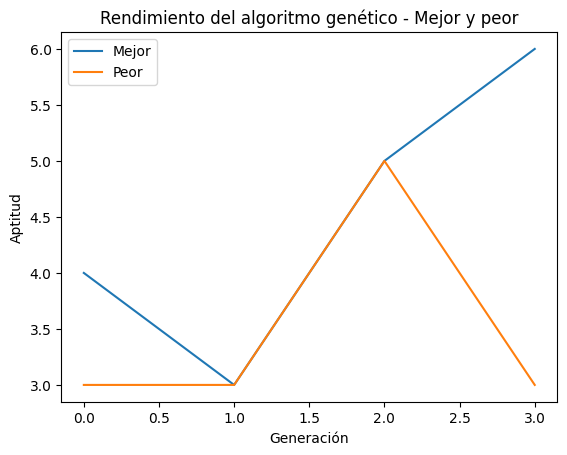

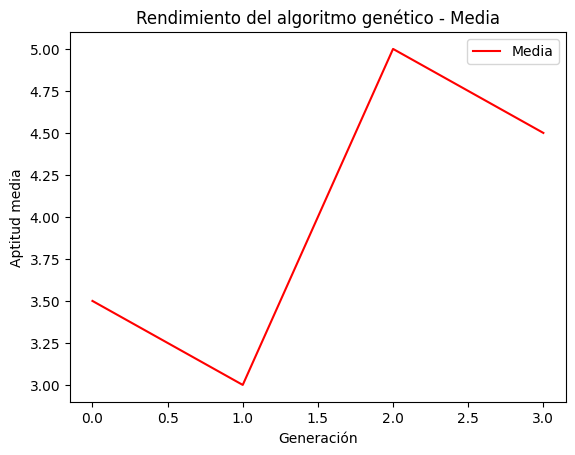

In [45]:
import matplotlib.pyplot as plt
import statistics

# Calculamos la aptitud media en cada generación
mejores_aptitudes = [max(x) for x in estats]
peores_aptitudes = [min(x) for x in estats]
avg_aptitudes = [statistics.mean(x) for x in estats]

# Creamos el gráfico para las aptitudes mejores y peores
plt.figure()
plt.plot(mejores_aptitudes, label='Mejor')
plt.plot(peores_aptitudes, label='Peor')
plt.xlabel('Generación')
plt.ylabel('Aptitud')
plt.title('Rendimiento del algoritmo genético - Mejor y peor')
plt.legend()
plt.show()

# Creamos un nuevo gráfico para la aptitud media
plt.figure()
plt.plot(avg_aptitudes, label='Media', color='red')  # Especificamos que la línea de la media sea roja
plt.xlabel('Generación')
plt.ylabel('Aptitud media')
plt.title('Rendimiento del algoritmo genético - Media')
plt.legend()
plt.show()


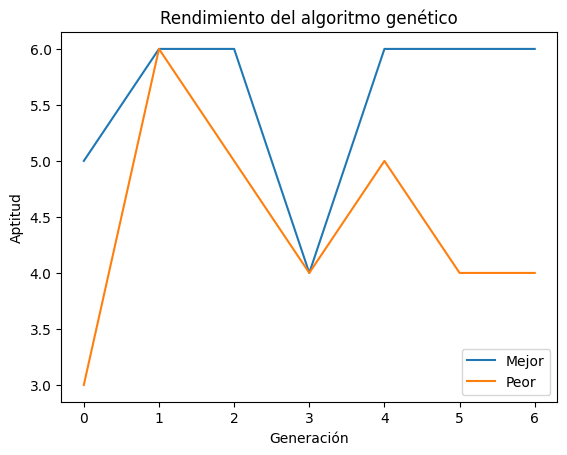

In [42]:
import statistics
# Desglosamos la lista en dos: una para el mejor y otra para el peor individuo
mejores_aptitudes = [max(x) for x in estats]
peores_aptitudes = [min(x) for x in estats]
avg_aptitudes = [statistics.mean(x) for x in estats]
# Ahora, creamos el gráfico
plt.plot(mejores_aptitudes, label='Mejor')
plt.plot(peores_aptitudes, label='Peor')
#plt.plot(avg_aptitudes, label='Media',color = 'black')
plt.xlabel('Generación')
plt.ylabel('Aptitud')
plt.title('Rendimiento del algoritmo genético')
plt.legend()
plt.show()

In [ ]:
for g in estats:
    print(g)

In [ ]:
import networkx as nx
import numpy as np

# Crea un grafo simple con cuatro nodos y cinco aristas
G = nx.Graph()
G.add_nodes_from(range(4))
G.add_edges_from([(0, 1), (0, 2), (0, 3), (1, 2), (2, 3)])

# Asigna pesos a las aristas
for u, v, d in G.edges(data=True):
    d['weight'] = np.random.rand()


In [ ]:
n = G.number_of_nodes()
w = compute_weight_matrix(G, n)
print(w)


In [ ]:
def prepare_state(partition):
    """
    Prepara un estado cuántico a partir de una cadena binaria dada.

    Parámetros
    ----------
    partition : str
        Una cadena binaria que representa la partición del grafo.

    Devoluciones
    -----------
    circuit : qiskit.circuit.quantumcircuit.QuantumCircuit
        Un circuito cuántico que representa el estado cuántico preparado.
    """
    circuit = QuantumCircuit(len(partition))

    for i in range(len(partition)):
        if partition[i] == '1':
            circuit.x(i)

    return circuit



In [ ]:
# Genera una cadena binaria aleatoria de longitud n
#partition = np.random.randint(2, size=n)
partition = [1, 0, 1, 1]  # Esto divide el grafo en los subconjuntos {0, 1} y {2, 3}

# Prepara un estado cuántico correspondiente a esta partición
state = prepare_state(partition)

# Mide la "energía" de este estado
energy = measure_cut(state, partition)
print(energy)
